## Exploration 7. 머신러닝 모델을 제품으로 만들어보자 : MLOps 기초

# Project 'CIFAR10 모델 튜닝 & 배포'

CIFAR10 프로젝트를 기반으로 데이터를 수정하고 하이퍼파라미터 튜닝을 한 다음 배포

**[내용 구성]**

0. Data Centric AI 맛보기
    - 잘못된 label 수정 (labelerrors.com 참고)
1. 모델 고정해서 사용
2. 하이퍼파라미터 튜닝
3. 모델배포(옵션)
4. TFLite 모델 생성(옵션)
5. 박찬성님의 TFX 프로젝트 분석(추가미션)

In [1]:
# # install KerasTuner 
# !pip install keras-tuner

In [2]:
# import library

# for file path access
import os

# for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

# for math operations
import numpy as np
# for managing tensors
import tensorflow as tf
# for model design
from tensorflow.keras import layers

# for keras tuner
import keras
import keras_tuner as kt
from sklearn.model_selection import train_test_split

# version check
print('tensorflow', tf.__version__)

tensorflow 2.15.0


# 0. Datacentric AI
- [labelerrors.com](https://labelerrors.com/)을 참고해서 데이터셋에 잘못된 label이 있는지 확인하고 수정

**[수정사항]**
- ID 값을 이용해서 총 22개 데이터 수정


## Load Data
- keras CIFAR10 dataset 활용


**cifar10 label 정보**
> Label  -	Description<br>
0	airplane<br>
1	automobile<br>
2	bird<br>
3	cat<br>
4	deer<br>
5	dog<br>
6	frog<br>
7	horse<br>
8	ship<br>
9	truck

In [17]:
# load cifar10 dataset from keras
cifar10 = keras.datasets.cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data() 

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

- 데이터가 어떤 방식으로 들어있는지, ID값을 사용할수 있는지 확인

In [4]:
x_train[:1]

array([[[[ 59,  62,  63],
         [ 43,  46,  45],
         [ 50,  48,  43],
         ...,
         [158, 132, 108],
         [152, 125, 102],
         [148, 124, 103]],

        [[ 16,  20,  20],
         [  0,   0,   0],
         [ 18,   8,   0],
         ...,
         [123,  88,  55],
         [119,  83,  50],
         [122,  87,  57]],

        [[ 25,  24,  21],
         [ 16,   7,   0],
         [ 49,  27,   8],
         ...,
         [118,  84,  50],
         [120,  84,  50],
         [109,  73,  42]],

        ...,

        [[208, 170,  96],
         [201, 153,  34],
         [198, 161,  26],
         ...,
         [160, 133,  70],
         [ 56,  31,   7],
         [ 53,  34,  20]],

        [[180, 139,  96],
         [173, 123,  42],
         [186, 144,  30],
         ...,
         [184, 148,  94],
         [ 97,  62,  34],
         [ 83,  53,  34]],

        [[177, 144, 116],
         [168, 129,  94],
         [179, 142,  87],
         ...,
         [216, 184, 140],
        

In [5]:
y_train[:3]

array([[6],
       [9],
       [9]], dtype=uint8)

- 데이터가 numpy array로 있다
- 변경해야하는 데이터는 y_train, y_test - label데이터이니 홈페이지의 잘못된 index의 이미지를 출력해보고 사진이 맞으면 해당 값을 변경해본다

In [13]:
# visualize image data with label using index
import cv2

def show_image_with_index(images, labels, indices):
    num_images = len(indices)
    ncols = min(num_images, 6) # maximum number of columns to display
    # nrows = (num_images - 1) // ncols + 1 # calculate the number of rows
    
    figs, axs = plt.subplots(figsize=(22,6), nrows=1, ncols=ncols)
    
    for i, index in enumerate(indices):
        axs[i].imshow(images[index])
        label = labels[index].squeeze()
        axs[i].set_title("Index: {}, Label: {} {}".format(index, labels[index], NAMES[int(label)]))
        axs[i].axis('off') # remove axis lines

    # remove any empty subplots if the number of images is not a multiple of ncols
    for i in range(num_images, ncols):
        axs[i // ncols, i % ncols].axis('off')

    plt.show()

In [7]:
# cifar10 label index
NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

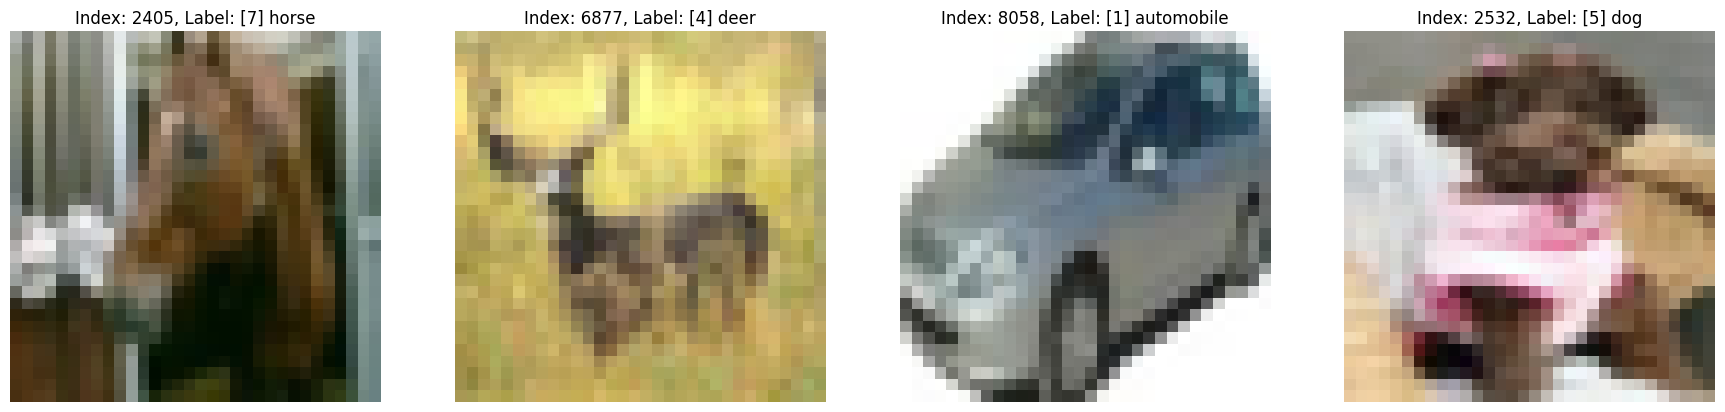

In [14]:
# 4 sample image
'''ID number on labelerrors.com'''
indices_to_visualize = [2405, 6877, 8058, 2532] 
show_image_with_index(x_train, y_train, indices_to_visualize)

- 데이터를 가져올때 train, test데이터로 나눠서 가져오면서 index값이 달라진걸지도 모르겠다
- 다시 데이터를 하나의 변수에 담아서 가져오고 index 값을 확인한다
    - [cleanlab github](https://github.com/cleanlab/label-errors/tree/main?tab=readme-ov-file), [tutorial](https://github.com/cleanlab/label-errors/blob/main/examples/Tutorial%20-%20How%20To%20Find%20Label%20Errors%20With%20CleanLab.ipynb)코드를 보고 index정보를 가져오려고 했지만 시간내에 작업하는게 어려워보인다
    - 지금까지 파악한 정보를 정리하면 
        - test 데이터셋에 대한 error만 정리되어있음
        - [json file](https://github.com/cleanlab/label-errors/blob/main/mturk/cifar10_mturk.json)에 원래 test dataset index가 적혀있다
- json 파일을 불러와서 해당 정보를 활용해서 코드로 레이블을 바로 수정하는 작업을 하면 좋겠지만(그게 가능하려나?) 시간이 부족하니 index 정보에 맞춰서 수작업으로 해당 레이블을 수정해본다

In [15]:
# load test set
_, (test_data, test_labels) = cifar10.load_data()

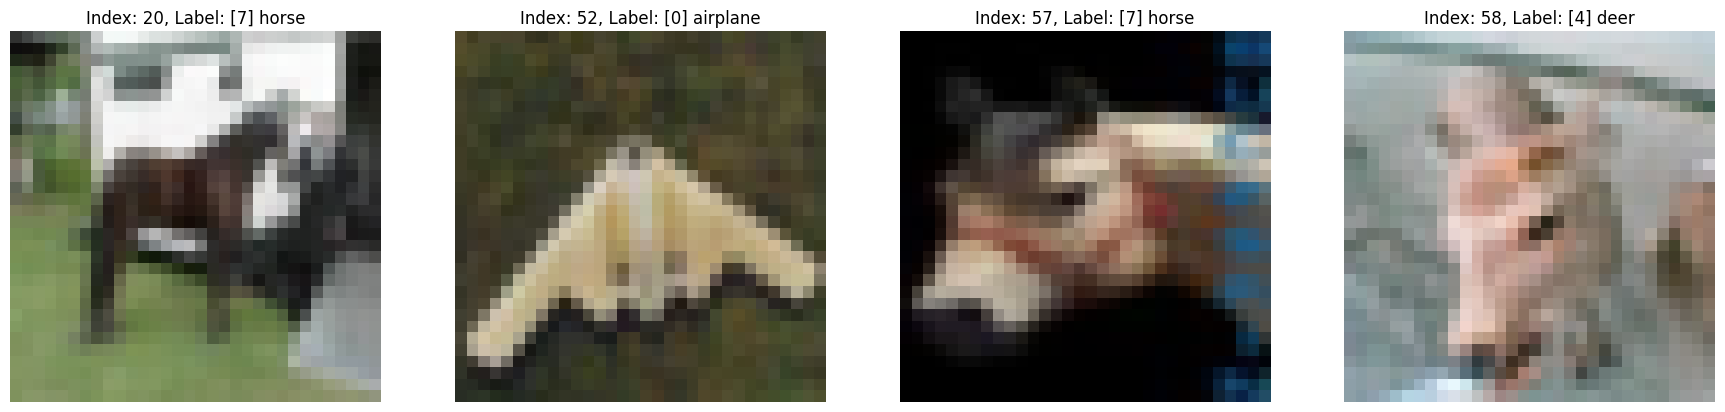

In [16]:
# 4 sample images check 
indices_to_visualize = [20, 52, 57, 58] 
show_image_with_index(test_data, test_labels, indices_to_visualize)

- 이것도 아닌것같다.
- 레이블 수정은 프로젝트 이후에 시간이 생기면 다시 도전!
- 다시 dataset 생성

In [18]:
# load dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data() 
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [21]:
# label encoding - categorical 
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

y_train[:3], y_test[:3]

(array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32),
 array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32))

In [22]:
# split data - train, validation = 8:2 
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.2)
print(X_train.shape)

(40000, 32, 32, 3)


---
# 1. 모델 고정해서 사용
<img src='./img/cifar10_model.png'>

- 사진과 동일한 모델을 생성

In [24]:
# build model
def build_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape = X_train.shape[1:], name='inputs'))

    # con2d layer 1
    model.add(layers.Conv2D(32, (2,2), activation='relu'))
    # average pooling layer 1
    model.add(layers.AveragePooling2D(1,1))
    # batch normalization 1
    model.add(layers.BatchNormalization())
    # conv2d layer 2
    model.add(layers.Conv2D(64, (2,2), activation='relu'))
    # average pooling layer 2
    model.add(layers.AveragePooling2D(1,1))
    # batch normalization 2
    model.add(layers.BatchNormalization())

    # flatten layer
    model.add(layers.Flatten())
    # dense layer
    model.add(layers.Dense(256, activation='relu'))
    # dropout layer - 50% 
    model.add(layers.Dropout(0.5))
    # output layer
    model.add(layers.Dense(10, activation='softmax', name = 'outputs'))

    # compile
    model.compile(optimizer = 'adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
    
    return model

In [25]:
# make model
model = build_model()

model.summary()

2024-01-29 16:36:18.778091: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-01-29 16:36:18.779526: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-01-29 16:36:18.779534: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-01-29 16:36:18.781046: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-01-29 16:36:18.782295: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 31, 32)        416       
                                                                 
 average_pooling2d (Average  (None, 31, 31, 32)        0         
 Pooling2D)                                                      
                                                                 
 batch_normalization (Batch  (None, 31, 31, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 64)        8256      
                                                                 
 average_pooling2d_1 (Avera  (None, 30, 30, 64)        0         
 gePooling2D)                                                    
                                                        

- 모델이 다르다.
- gpt도움을 받아서 모델생성 함수 수정

In [26]:
def build_modified_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=X_train.shape[1:], name='inputs'))

    # Conv2D layer 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='valid'))
    # Average Pooling layer 1
    model.add(layers.AveragePooling2D(2, 2))
    # Batch Normalization 1
    model.add(layers.BatchNormalization())

    # Conv2D layer 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='valid'))
    # Average Pooling layer 2
    model.add(layers.AveragePooling2D(2, 2))
    # Batch Normalization 2
    model.add(layers.BatchNormalization())

    # Flatten layer
    model.add(layers.Flatten())
    # Dense layer
    model.add(layers.Dense(256, activation='relu'))
    # Dropout layer - 50%
    model.add(layers.Dropout(0.5))
    # Output layer
    model.add(layers.Dense(10, activation='softmax', name='outputs'))

    # Compile
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [28]:
# remake model
model = build_modified_model()

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 average_pooling2d_4 (Avera  (None, 15, 15, 32)        0         
 gePooling2D)                                                    
                                                                 
 batch_normalization_4 (Bat  (None, 15, 15, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 average_pooling2d_5 (Avera  (None, 6, 6, 64)          0         
 gePooling2D)                                                    
                                                      

- 같아졌다! 시간이 없으니 일단 패스

# 2. 하이퍼파라미터 튜닝

## DeepTuner
- `kerastuner.Tuner`를 인자로 하는 class
- `run_trial`,`save_model`,`load_model` 함수 실행
    - `run_trial`에서 중요한 부분! : `hypermodel`, `trial`
  
  
**KerasTuner의 hypermodel**

- 모델 공유 및 재사용하기 위해 검색 공간을 캡슐화하는 모델
- `hp` 인수를 사용해서 `keras.Model` 생성
    - 만들고 싶은 모델을 쌓는 과정에서 하이퍼파라미터 튜닝을 위한 검색공간을 만들때 hp 인수를 사용해서 모델 생성
- `build` 메소드를 활용하면 **모델빌드 + 하이퍼파라미텨 튜닝 시작**


**KerasTuner의 trial**
- Oracle에 속하는 class
    - Oracle : KerasTuner`의 모든 검색 알고리즘에서 사용하는 기본 클래스
- 종류 : RandomSearchOracle, BayesianOptimizationOracle, HyperbandOracle
    - KerasTuner가 하이퍼파라미터를 정할때 사용하는 알고리즘
- `trial.hyperparameter` : Oracle이 찾아야하는 하이퍼파라미터
    - = `hypermodel`의 `hp`

In [32]:
class DeepTuner(kt.Tuner):
    def run_trial(self, trial, X, y, validation_data, **fit_kwargs):
        # model은 고정이니 이 부분은 제외
        # model = self.hypermodel.build(trial.hyperparameters)      # 모델빌드 + 하이퍼파라미터 튜닝 시작
        model.fit(X, y, batch_size=trial.hyperparameters.Choice(  # trial : batch size 검색
            'batch_size', [16, 32]), **fit_kwargs)


        X_val, y_val = validation_data
        eval_scores = model.evaluate(X_val, y_val)
        return {name: value for name, value in zip(
            model.metrics_names,
            eval_scores)}

## KerasTuner 정의 & 파라미터 탐색
- BayesianOptimizationOracle을 사용
    - Objective :accuracy, max
    - trial : 10
- `search` : 파라미터 탐색 함수
- 무거운 모델을 돌릴경우 하이퍼파라미터 튜닝 작업 소요시간이 늘어남
    - **search epoch를 3-4로 작게 설정 -> 최고의 하이퍼파라미터 추출 -> 본격 모델학습때 epoch를 넉넉하게 설정**

In [33]:
# make keras tuner
my_keras_tuner = DeepTuner(
    oracle=kt.oracles.BayesianOptimizationOracle(
        objective=kt.Objective('accuracy', 'max'),
        max_trials=10,
        seed=42),
    # hypermodel=build_model,  # 모델은 고정되어있으니 이 부분은 제외
    overwrite=True,
    project_name='my_keras_tuner')

# Navigate parameters
my_keras_tuner.search(
    X_train, y_train, validation_data=(X_val, y_val), epochs=3)

Trial 2 Complete [00h 00m 57s]
accuracy: 0.5863999724388123

Best accuracy So Far: 0.5863999724388123
Total elapsed time: 00h 02m 33s


## Select best hyperparameter
- `KerasTuner.get_best_hyperparamters`를 이용해서 가장 좋은 하이퍼파라미터 추출
- 추출한 하이퍼파라미터를 build_model()에 넣어서 모델 생성

In [34]:
# Extract the best hyperparameters
best_hps = my_keras_tuner.get_best_hyperparameters(num_trials=10)[0]

# Make the best model with the hyperparameters
model = build_model(best_hps)
model.summary()

TypeError: build_model() takes 0 positional arguments but 1 was given

- 모델은 고정이라서 hp 인수를 받지 않는 형식으로 모델을 만들었는데, 받아서 만들어야했나보다.

# ===== SUMMARY =====
이론은 대충 어떤 흐름으로 진행되는지는 이해했지만 실제로 코드를 만들때 어떻게 적용해야하는지 어려웠다. keras tuner도 문제였지만 앞서서 labelerrors.com에서 label을 바꾸는 부분을 이해하느라 시간을 너무 많이 소요했다. 공부할게 많다:)

# ===== KPT ======

**[KEEP]**
- 새로운 코드와 이론을 보는걸 두려워하지않았다:)

**[PROBLEM]**
- keras tuner의 실제 적용방식에 대한 이해가 부족하다. 모델을 고정시킨 경우엔 어떻게 모델을 만들고 tuner의 hp 인수를 설정해야하는지, 모델빌드는 어떻게 해야하는지 이해가 안되었다.
- 레이블을 변경하는데 실패. 해당 홈페이지에 어떻게 레이블 정보를 만들어두었는지 내용을 파악하는데 시간이 너무 오래 걸렸다.

**[TRY]**
- 레이블을 고치는 부분부터 다시 차근차근 시도해본다
- keras tuner도 정답지 노트북을 하나 찾아서 다시 필사해가며 공부한다